# Predict Future Price

---

### Import Libraries and Dependencies

In [1]:
# Initial imports
import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

import talib

### Read CSV / API into Pandas DataFrame

In [2]:
# Loading data
file_path = Path("Resources/Yahoo Finance/All Yahoo Data.csv")
All_Yahoo_Data = pd.read_csv(file_path, index_col="Date")

# Get list of all tickers contained in the DataFrame
tickers = All_Yahoo_Data.Ticker.unique().tolist()

# Preview
All_Yahoo_Data.head()

,High,Low,Open,Close,Volume,Adj Close,Ticker
Date,,,,,,,
2010-01-04,7.660714,7.585000,7.622500,7.643214,493729600.0,6.593423,AAPL
2010-01-05,7.699643,7.616071,7.664286,7.656429,601904800.0,6.604822,AAPL
2010-01-06,7.686786,7.526786,7.656429,7.534643,552160000.0,6.499765,AAPL
2010-01-07,7.571429,7.466071,7.562500,7.520714,477131200.0,6.487749,AAPL
2010-01-08,7.571429,7.466429,7.510714,7.570714,447610800.0,6.530882,AAPL


### Calculate Indicators and Prepare Data

In [3]:
def add_indicators_and_signals(df):

    df = df.drop(["Adj Close", "Ticker"], axis=1)
    stock_high = df['High']
    stock_low = df['Low']
    stock_open = df['Open']
    stock_close = df['Close']
    stock_volume = df['Volume']
    
    # MACD, MACD Histogram
    df['MACD'], df['MSIG'], macdhist = talib.MACD(stock_close, fastperiod=12, slowperiod=26, signalperiod=9)
    
    # Compute Average Directional Index (ADX)
    df['ADX'] = talib.ADX(stock_high, stock_low, stock_close, timeperiod=14)
    
    # Compute Relatie Strength Index (RSI)
    df['RSI'] = talib.RSI(stock_close, timeperiod=14)
    
    # Compute Bollinger Bands
    df['BB Upper'], df['BB middle'], df['BB Lower'] = talib.BBANDS(stock_close, timeperiod=26)
    
    # Compute Force Index
    df['FI'] = df['Volume'] * (df['Close'] - df['Close'].shift(1))
    df['EFI'] = talib.EMA(df['FI'], timeperiod=13)

    # Remove Scientific Notation from columns FI and EFI
    pd.options.display.float_format = '{:.2f}'.format
    
    # ------------ SMA 50 AND 200 DAYS ------------
    # Calculate 50 day simple movering average
    df['SMA 50'] = df['Close'].transform(lambda x: x.rolling(window = 50).mean())

    # Calculate 200 day simple movering average
    df['SMA 200'] = df['Close'].transform(lambda x: x.rolling(window = 200).mean())

    # Calculate simple moving average ratio to capture the relationship between the two moving averages
    df['SMA 200/50'] = df['SMA 200'] / df['SMA 50']
    
    # ------------ SMA 5 AND 15 DAYS ------------
    # Calculate 5 day simple movering average
    df['SMA 5'] = df['Close'].transform(lambda x: x.rolling(window = 5).mean())

    # Calculate 15 day simple movering average
    df['SMA 15'] = df['Close'].transform(lambda x: x.rolling(window = 15).mean())

    # Calculate simple moving average ratio to capture the relationship between the two moving averages
    df['SMA 15/5'] = df['SMA 15'] / df['SMA 5']
    
    # ATR - Average True Range
    # ???
    
    ##############################################################
    
    # Calculate daily return
    df['Returns'] = df['Close'].pct_change()
    # Create Target column
    df['Target'] = np.where(df['Returns'] >= 0, 1.0, -1)
    
    # Shift Target column by index 1 TODO ???????????? CHECK DIRECTIO
    df['Target'] = df['Target'].shift(-1)

    # Replacing infinite with nan 
    df.replace([np.inf, -np.inf], np.nan, inplace=True) 

    # Dropping all the rows with nan values 
    df.dropna(inplace=True) 
    
    return df

In [4]:
def random_forest(df, ticker):
    # Split Train and Test Data Sets
    # Define features set
    X = df.copy()
    X.drop(['Returns', 'Target'], axis=1, inplace=True)
    
    # Define target vector
    y = df["Target"].ravel()
    
    # Splitting into Train and Test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)
    
    # Creating StandardScaler instance
    scaler = StandardScaler()
    
    # Fitting Standard Scaller
    X_scaler = scaler.fit(X_train)
    
    # Scaling data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # Create a random forest classifier
    rf_model = RandomForestClassifier(n_estimators=500, random_state=1)
    
    # Fitting the model
    rf_model = rf_model.fit(X_train_scaled, y_train)
    
    # Making predictions using the testing data
    predictions = rf_model.predict(X_test_scaled)
    
    # Calculating the confusion matrix
    cm = confusion_matrix(y_test, predictions)
    cm_df = pd.DataFrame(
        cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
    )

    # Calculating the accuracy score
    acc_score = accuracy_score(y_test, predictions)
    
    # Displaying results
    print(f'{ticker}: Confusion Matrix')
    display(cm_df)
    print(f"Accuracy Score : {acc_score}")
    print("Classification Report")
    print(classification_report(y_test, predictions))
    
    return rf_model, X.columns

In [5]:
def features_importances(ticker, rf_model, X_columns):
    # Random Forests in sklearn will automatically calculate feature importance
    importances = rf_model.feature_importances_
    
    # We can sort the features by their importance
    sorted(zip(rf_model.feature_importances_, X_columns), reverse=True)
    
    # Visualize the features by importance
    importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X_columns), reverse=True))
    importances_df.set_index(importances_df[1], inplace=True)
    importances_df.drop(columns=1, inplace=True)
    importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
    importances_sorted = importances_df.sort_values(by='Feature Importances')
    
    chart = importances_sorted.plot(kind='barh', color='lightgreen', title= f'{ticker} Features Importances', legend=False) 
    return chart


### Run the Random Forest Model for only 1 ticker

In [6]:
# ticker = 'GOOG'
# df = All_Yahoo_Data.loc[All_Yahoo_Data['Ticker'] == ticker]

# # Calculate indicators and prepare data
# df = add_indicators_and_signals(df)

# # Make predictions and return confusion matrix
# rf_model, X_columns = random_forest(df, ticker)

# # Display importance features graph
# features_importances(ticker, rf_model, X_columns)

### Run the Random Forest Model for All Tickers


----------------------- AAPL -----------------------

AAPL: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,150,191
Actual 1,151,203


Accuracy Score : 0.5079136690647482
Classification Report
              precision    recall  f1-score   support

        -1.0       0.50      0.44      0.47       341
         1.0       0.52      0.57      0.54       354

    accuracy                           0.51       695
   macro avg       0.51      0.51      0.51       695
weighted avg       0.51      0.51      0.51       695


----------------------- AMZN -----------------------

AMZN: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,159,155
Actual 1,161,220


Accuracy Score : 0.5453237410071943
Classification Report
              precision    recall  f1-score   support

        -1.0       0.50      0.51      0.50       314
         1.0       0.59      0.58      0.58       381

    accuracy                           0.55       695
   macro avg       0.54      0.54      0.54       695
weighted avg       0.55      0.55      0.55       695


----------------------- BABA -----------------------

BABA: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,72,91
Actual 1,70,106


Accuracy Score : 0.5250737463126843
Classification Report
              precision    recall  f1-score   support

        -1.0       0.51      0.44      0.47       163
         1.0       0.54      0.60      0.57       176

    accuracy                           0.53       339
   macro avg       0.52      0.52      0.52       339
weighted avg       0.52      0.53      0.52       339


----------------------- EMR -----------------------

EMR: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,147,182
Actual 1,144,222


Accuracy Score : 0.5309352517985612
Classification Report
              precision    recall  f1-score   support

        -1.0       0.51      0.45      0.47       329
         1.0       0.55      0.61      0.58       366

    accuracy                           0.53       695
   macro avg       0.53      0.53      0.53       695
weighted avg       0.53      0.53      0.53       695


----------------------- EURUSD=X -----------------------

EURUSD=X: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,201,162
Actual 1,157,196


Accuracy Score : 0.5544692737430168
Classification Report
              precision    recall  f1-score   support

        -1.0       0.56      0.55      0.56       363
         1.0       0.55      0.56      0.55       353

    accuracy                           0.55       716
   macro avg       0.55      0.55      0.55       716
weighted avg       0.55      0.55      0.55       716


----------------------- EXC -----------------------

EXC: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,142,191
Actual 1,144,218


Accuracy Score : 0.5179856115107914
Classification Report
              precision    recall  f1-score   support

        -1.0       0.50      0.43      0.46       333
         1.0       0.53      0.60      0.57       362

    accuracy                           0.52       695
   macro avg       0.51      0.51      0.51       695
weighted avg       0.52      0.52      0.51       695


----------------------- F -----------------------

F: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,163,167
Actual 1,179,186


Accuracy Score : 0.5021582733812949
Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.49      0.49       330
         1.0       0.53      0.51      0.52       365

    accuracy                           0.50       695
   macro avg       0.50      0.50      0.50       695
weighted avg       0.50      0.50      0.50       695


----------------------- GBPUSD=X -----------------------

GBPUSD=X: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,198,150
Actual 1,178,190


Accuracy Score : 0.5418994413407822
Classification Report
              precision    recall  f1-score   support

        -1.0       0.53      0.57      0.55       348
         1.0       0.56      0.52      0.54       368

    accuracy                           0.54       716
   macro avg       0.54      0.54      0.54       716
weighted avg       0.54      0.54      0.54       716


----------------------- Gold -----------------------

Gold: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,162,185
Actual 1,159,189


Accuracy Score : 0.5050359712230216
Classification Report
              precision    recall  f1-score   support

        -1.0       0.50      0.47      0.49       347
         1.0       0.51      0.54      0.52       348

    accuracy                           0.51       695
   macro avg       0.51      0.50      0.50       695
weighted avg       0.51      0.51      0.50       695


----------------------- GOOG -----------------------

GOOG: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,156,172
Actual 1,162,205


Accuracy Score : 0.5194244604316547
Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.48      0.48       328
         1.0       0.54      0.56      0.55       367

    accuracy                           0.52       695
   macro avg       0.52      0.52      0.52       695
weighted avg       0.52      0.52      0.52       695


----------------------- JPM -----------------------

JPM: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,152,170
Actual 1,170,203


Accuracy Score : 0.5107913669064749
Classification Report
              precision    recall  f1-score   support

        -1.0       0.47      0.47      0.47       322
         1.0       0.54      0.54      0.54       373

    accuracy                           0.51       695
   macro avg       0.51      0.51      0.51       695
weighted avg       0.51      0.51      0.51       695


----------------------- KO -----------------------

KO: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,147,168
Actual 1,170,210


Accuracy Score : 0.5136690647482014
Classification Report
              precision    recall  f1-score   support

        -1.0       0.46      0.47      0.47       315
         1.0       0.56      0.55      0.55       380

    accuracy                           0.51       695
   macro avg       0.51      0.51      0.51       695
weighted avg       0.51      0.51      0.51       695


----------------------- MMM -----------------------

MMM: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,140,178
Actual 1,144,233


Accuracy Score : 0.5366906474820143
Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.44      0.47       318
         1.0       0.57      0.62      0.59       377

    accuracy                           0.54       695
   macro avg       0.53      0.53      0.53       695
weighted avg       0.53      0.54      0.53       695


----------------------- Oil -----------------------

Oil: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,46,138
Actual 1,73,340


Accuracy Score : 0.6465661641541038
Classification Report
              precision    recall  f1-score   support

        -1.0       0.39      0.25      0.30       184
         1.0       0.71      0.82      0.76       413

    accuracy                           0.65       597
   macro avg       0.55      0.54      0.53       597
weighted avg       0.61      0.65      0.62       597


----------------------- PFE -----------------------

PFE: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,163,166
Actual 1,182,184


Accuracy Score : 0.49928057553956834
Classification Report
              precision    recall  f1-score   support

        -1.0       0.47      0.50      0.48       329
         1.0       0.53      0.50      0.51       366

    accuracy                           0.50       695
   macro avg       0.50      0.50      0.50       695
weighted avg       0.50      0.50      0.50       695


----------------------- SSNLF -----------------------

SSNLF: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,0,5
Actual 1,0,217


Accuracy Score : 0.9774774774774775
Classification Report
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         5
         1.0       0.98      1.00      0.99       217

    accuracy                           0.98       222
   macro avg       0.49      0.50      0.49       222
weighted avg       0.96      0.98      0.97       222


----------------------- SIEGY -----------------------



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SIEGY: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,173,159
Actual 1,157,206


Accuracy Score : 0.5453237410071943
Classification Report
              precision    recall  f1-score   support

        -1.0       0.52      0.52      0.52       332
         1.0       0.56      0.57      0.57       363

    accuracy                           0.55       695
   macro avg       0.54      0.54      0.54       695
weighted avg       0.55      0.55      0.55       695


----------------------- SPG -----------------------

SPG: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,145,151
Actual 1,187,212


Accuracy Score : 0.5136690647482014
Classification Report
              precision    recall  f1-score   support

        -1.0       0.44      0.49      0.46       296
         1.0       0.58      0.53      0.56       399

    accuracy                           0.51       695
   macro avg       0.51      0.51      0.51       695
weighted avg       0.52      0.51      0.52       695


----------------------- TSLA -----------------------

TSLA: Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,138,174
Actual 1,167,180


Accuracy Score : 0.48254931714719274
Classification Report
              precision    recall  f1-score   support

        -1.0       0.45      0.44      0.45       312
         1.0       0.51      0.52      0.51       347

    accuracy                           0.48       659
   macro avg       0.48      0.48      0.48       659
weighted avg       0.48      0.48      0.48       659



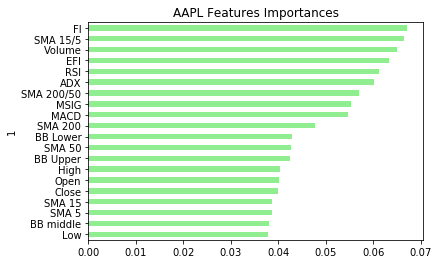

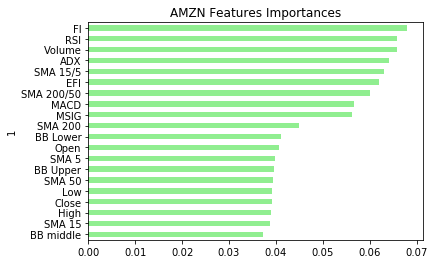

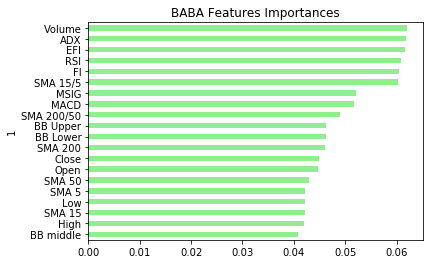

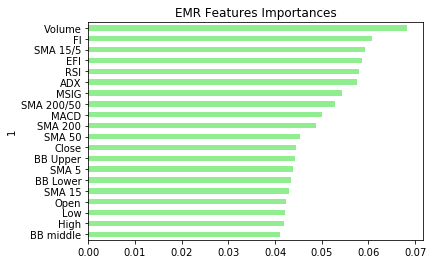

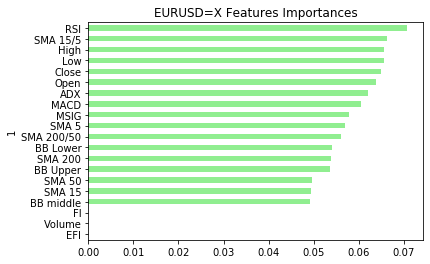

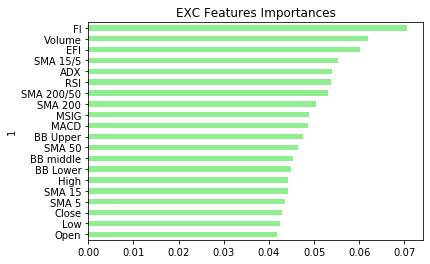

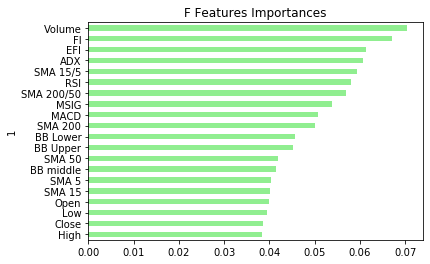

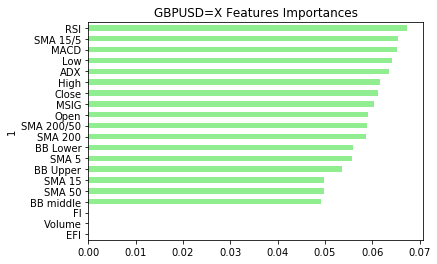

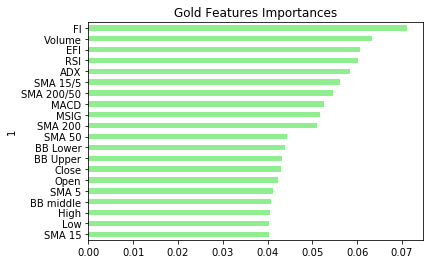

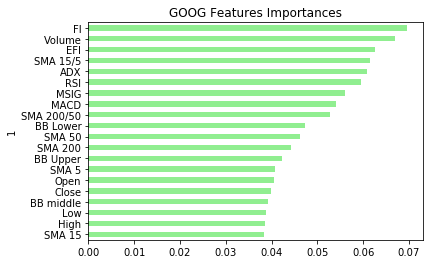

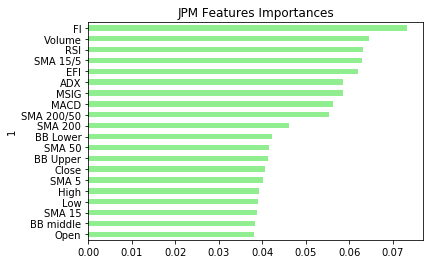

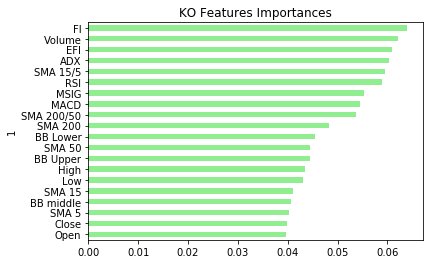

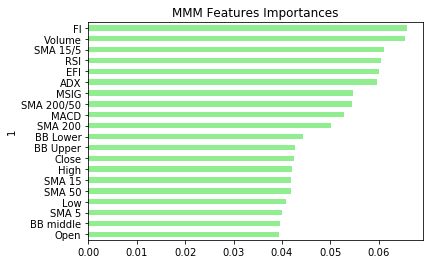

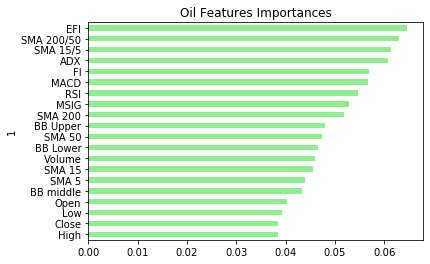

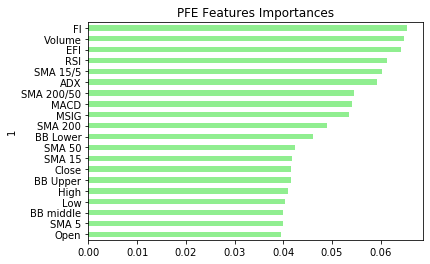

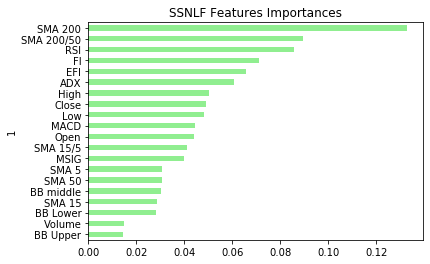

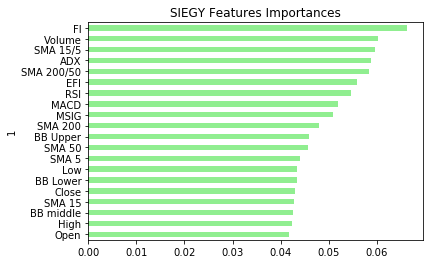

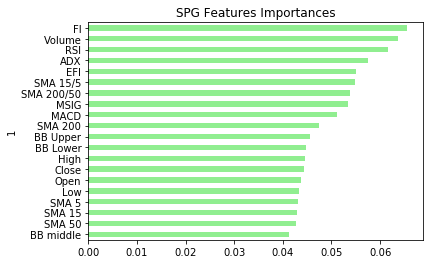

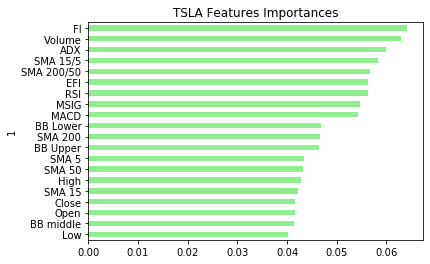

In [7]:
for ticker in tickers:
    print(f'\n----------------------- {ticker} -----------------------\n')
    df = All_Yahoo_Data.loc[All_Yahoo_Data['Ticker'] == ticker]

    # Calculate indicators and prepare data
    df = add_indicators_and_signals(df)

    # Make predictions and display confusion matrix
    rf_model, X_columns = random_forest(df, ticker)

    # Display importance features graph
    features_importances(ticker, rf_model, X_columns)
